In [250]:
import pandas as pd
from tqdm.auto import tqdm
from util import *
from stationUtil import line_range, get_line, line_num_to_range
from graph import *
from glob import glob

In [251]:
# DEMAND_GRAPH_PATH = "../trimmed_data/demand_graph.pickle"
# demand = loadPickle(DEMAND_GRAPH_PATH)
f_list = glob("../trimmed_data/A001_20*.csv.*")
demand = [loadPickle(p) for p in f_list]

In [252]:
demand[0].keys().__len__()

12468

In [253]:
def od_metric(scode_start, scode_end):
    for d in demand:
        try:
            return d[(scode_start, scode_end)]
        except:
            return 0

In [254]:
# 아무것도 제외 하지 않으면 완행열차와 동일하다.
UNITFACTOR_P1KM_TO_1KM = 1 / 10
UNITFACTOR_1SEC_TO_1HOUR = 1 / 3600
EXCLUDE_STATION = []
g_time = time_weight_graph(exclude_list=EXCLUDE_STATION)
g_dist = dist_weight_graph()

sCode_start, sCode_end = 95, 301
calc_total_path_weight(g_time, sCode_start, sCode_end), calc_total_path_weight(
    g_dist, sCode_start, sCode_end
)  # (Second, 0.1km)

(4547.9284707102415, 331)

In [255]:
from stationUtil import *

subway_graph_index, _ = fn_export_subway_graph(
    loadPickle(PATH_INTER_STATION_SPEND_TIME)
)


def unit_tranfer_flux_metric(scode_start, scode_end, g_dist=g_dist):
    path_dist = (
        calc_total_path_weight(g_dist, scode_start, scode_end) * UNITFACTOR_P1KM_TO_1KM
    )
    path_od = od_metric(scode_start, scode_end)
    return path_dist * path_od

len(subway_graph) == len(interval_time) :  True


In [256]:
# Calc Flux Metric
flux_metric = {}
s_namecode = loadPickle("../trimmed_data/stationNameCode.pickel").values()
s_namecode = set(s_namecode)

for target_scode in tqdm(s_namecode):
    for calc_scode in s_namecode:
        flux = unit_tranfer_flux_metric(target_scode, calc_scode)
        flux_metric[(target_scode, calc_scode)] = flux

flux_IO = {scode: [0, 0] for scode in s_namecode}
for target_scode in tqdm(s_namecode):
    flux_IN = []
    flux_OUT = []
    for calc_scode in s_namecode:
        flux_IN.append(flux_metric[(target_scode, calc_scode)])
        flux_OUT.append(flux_metric[(calc_scode, target_scode)])
    flux_IO[target_scode][0] = round(sum(flux_IN))
    flux_IO[target_scode][1] = round(sum(flux_OUT))

flux_IO[301] = flux_IO[208]
flux_IO[401] = flux_IO[309]

100%|██████████| 114/114 [00:00<00:00, 9509.38it/s]


In [257]:
# 장산역
flux_IO[301]

[2979085, 2928889]

In [258]:
# FLUX_METRIC = pd.DataFrame(flux_IO).T
# FLUX_METRIC = FLUX_METRIC.rename(columns={0:"IN_FLUX",1:"OUT_FLUX"})
# FLUX_METRIC.index.name="scode"

# # 정규화함. 호선 별로
# for line in (1,2,3,4):
#     FLUX_METRIC.loc[line_num_to_range(line), :] = (
#         10
#         * (
#             FLUX_METRIC.loc[line_num_to_range(line), :]
#             - FLUX_METRIC.loc[line_num_to_range(line), :].min()
#         )
#         / (
#             FLUX_METRIC.loc[line_num_to_range(line), :].max()
#             - FLUX_METRIC.loc[line_num_to_range(line), :].min()
#         )
#     )

# FLUX_METRIC.loc[line_num_to_range(4), :]

In [259]:
FLUX_METRIC = pd.DataFrame(flux_IO).T
FLUX_METRIC = FLUX_METRIC.rename(columns={0: "IN_FLUX", 1: "OUT_FLUX"})
FLUX_METRIC.index.name = "scode"
# 정규화함. 호선 별로
for line in (1, 2, 3, 4):
    print(line_num_to_range(line))
    FLUX_METRIC.loc[line_num_to_range(line), "IN_FLUX":"OUT_FLUX"] = FLUX_METRIC.loc[line_num_to_range(line), "IN_FLUX":"OUT_FLUX"].rank(method="min")
    FLUX_METRIC.loc[line_num_to_range(line), "IN_FLUX":"OUT_FLUX"] /= FLUX_METRIC.loc[line_num_to_range(line), "IN_FLUX":"OUT_FLUX"].max()
    FLUX_METRIC.loc[line_num_to_range(line), "IN_FLUX":"OUT_FLUX"] *= 10

FLUX_METRIC.loc[line_num_to_range(4), :]

[95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]
[201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243]
[301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317]
[401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414]


,IN_FLUX,OUT_FLUX
scode,,
401,10.000000,10.000000
402,3.571429,5.000000
403,5.714286,7.857143
404,2.142857,2.142857
405,6.428571,5.714286
406,7.142857,7.142857
407,5.000000,4.285714
408,4.285714,2.857143
409,2.857143,3.571429


In [260]:
# # 역명을 코드로 변환하기 위한 data
# SAVE_PATH = "../database"
# IMPLICIT_METRIC = pd.read_csv(f"{SAVE_PATH}/IMPLICIT_METRIC.csv", encoding="UTF-8")
# IMPLICIT_METRIC = IMPLICIT_METRIC.set_index("scode")


# # 정규화함. 호선 별로
# for line in (1, 2, 3, 4):
#     IMPLICIT_METRIC.loc[line_num_to_range(line), :] = (
#         10
#         * (
#             IMPLICIT_METRIC.loc[line_num_to_range(line), :]
#             - IMPLICIT_METRIC.loc[line_num_to_range(line), :].min()
#         )
#         / (
#             IMPLICIT_METRIC.loc[line_num_to_range(line), :].max()
#             - IMPLICIT_METRIC.loc[line_num_to_range(line), :].min()
#         )
#     )

# IMPLICIT_METRIC.head()

In [261]:
SAVE_PATH = "../database"
IMPLICIT_METRIC = pd.read_csv(f"{SAVE_PATH}/IMPLICIT_METRIC.csv", encoding="UTF-8")
IMPLICIT_METRIC = IMPLICIT_METRIC.set_index("scode")

# 정규화함. 호선 별로
for line in (1, 2, 3, 4):
    print(line_num_to_range(line))
    IMPLICIT_METRIC.loc[line_num_to_range(line), "직장인구":"유동인구"] = IMPLICIT_METRIC.loc[line_num_to_range(line), "직장인구":"유동인구"].rank(method="min")
    IMPLICIT_METRIC.loc[line_num_to_range(line), "직장인구":"유동인구"] /= IMPLICIT_METRIC.loc[line_num_to_range(line), "직장인구":"유동인구"].max()
    IMPLICIT_METRIC.loc[line_num_to_range(line), "직장인구":"유동인구"] *= 10

IMPLICIT_METRIC.loc[line_num_to_range(4), :]

[95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]
[201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243]
[301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317]
[401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414]


,직장인구,주거인구,유동인구
scode,,,
401,6.428571,7.142857,7.857143
402,7.857143,8.571429,9.285714
403,10.000000,10.000000,10.000000
404,9.285714,9.285714,8.571429
405,8.571429,7.857143,7.142857
406,7.142857,6.428571,6.428571
407,5.714286,5.714286,5.714286
408,5.000000,5.000000,5.000000
409,4.285714,4.285714,4.285714


In [262]:
FLUX_METRIC_MEAN = FLUX_METRIC.mean(axis=1)
FLUX_METRIC_MEAN.head()

scode
95    3.375
96    1.750
97    3.250
98    1.125
99    1.625
dtype: float64

In [263]:
IMPLICIT_METRIC_MEAN = IMPLICIT_METRIC.mean(axis=1)
IMPLICIT_METRIC_MEAN.head()

scode
95    0.750000
96    1.666667
97    3.250000
98    4.916667
99    5.000000
dtype: float64

In [264]:
DF_METRIC = pd.concat([FLUX_METRIC_MEAN, IMPLICIT_METRIC_MEAN], axis=1)
DF_METRIC = DF_METRIC.rename(columns={0: "FLUX", 1: "IMPLICIT"})

DF_METRIC["LINE"] = DF_METRIC.index
DF_METRIC["LINE"] = DF_METRIC["LINE"].apply(get_line)
DF_METRIC

,FLUX,IMPLICIT,LINE
scode,,,
95,3.375000,0.750000,1
96,1.750000,1.666667,1
97,3.250000,3.250000,1
98,1.125000,4.916667,1
99,1.625000,5.000000,1
...,...,...,...
410,0.714286,3.571429,4
411,9.285714,2.380952,4
412,7.500000,2.619048,4


In [265]:
def calc_grade(_tup):
    flux, impl = _tup
    if flux < 2 and impl < 2:
        return 5
    elif flux < 4 and impl < 4:
        return 4
    elif flux < 6 and impl < 6:
        return 3
    elif flux < 8 and impl < 8:
        return 2
    elif flux <= 10 and impl <= 10:
        return 1


# Calculate GRADE
DF_METRIC["GRADE"] = (
    DF_METRIC["FLUX"].apply(str) + "," + DF_METRIC["IMPLICIT"].apply(str)
)
DF_METRIC["GRADE"] = DF_METRIC["GRADE"].apply(
    lambda _X: tuple(map(float, _X.split(",")))
)
DF_METRIC["GRADE"] = DF_METRIC["GRADE"].apply(calc_grade)

DF_METRIC

,FLUX,IMPLICIT,LINE,GRADE
scode,,,,
95,3.375000,0.750000,1,4
96,1.750000,1.666667,1,5
97,3.250000,3.250000,1,4
98,1.125000,4.916667,1,3
99,1.625000,5.000000,1,3
...,...,...,...,...
410,0.714286,3.571429,4,4
411,9.285714,2.380952,4,1
412,7.500000,2.619048,4,2


In [266]:
GRADE_CONDITION = [DF_METRIC["GRADE"] == g for g in (1, 2, 3, 4, 5)]
LINE_CONDITION = [DF_METRIC["LINE"] == l for l in (1, 2, 3, 4)]

In [276]:
def draw_func(LINE):
    ax = DF_METRIC[LINE_CONDITION[LINE - 1]].plot.scatter(
        x="FLUX", y="IMPLICIT", c="GRADE", colormap="viridis"
    )
    return ax, ax.get_figure()


def get_grade(LINE, GRADE):
    arr = []
    for g in range(GRADE):
        arr.extend(
            DF_METRIC[LINE_CONDITION[LINE - 1] & GRADE_CONDITION[g - 1]].index.to_list()
        )
    arr.sort()

    return arr


def get_exclude_list(LINE, GRADE):
    sCodes = [*line_num_to_range(LINE)]
    for grade in get_grade(LINE, GRADE):
        if grade in sCodes:
            sCodes.pop(sCodes.index(grade))

    if [*line_num_to_range(LINE)][0] in sCodes:
        sCodes.pop(0)
    if [*line_num_to_range(LINE)][-1] in sCodes:
        sCodes.pop(-1)

    return sCodes


assert 0 == len(set(get_grade(1, 1)) & set(get_exclude_list(1, 1)))

(34.83870967741935, 1240)

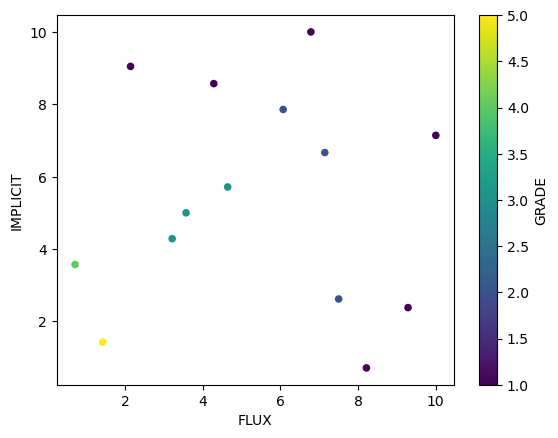

In [292]:
LINE,GRADE=(4,1)
EXCLUDE_STATION = get_exclude_list(LINE,GRADE)
g_time = time_weight_graph(exclude_list=EXCLUDE_STATION)
g_dist = dist_weight_graph()

draw_func(LINE)
calc_line_speed(LINE,g_dist=g_dist,g_time=g_time), calc_line_spend_time(LINE,g_time=g_time)